In [1]:
import numpy as np
import matplotlib.pyplot as plt

# for norm.pdf
from scipy.stats import norm

In [2]:
# generate data for naive bayes classification
def get_class0_data(n=500):
    return np.random.multivariate_normal([1, 0], [[1, 0.75], [0.75, 1]], n)

def get_class1_data(n=500):
    return np.random.multivariate_normal([0, 1], [[1, 0.75], [0.75, 1]], n)

In [3]:
x1 = get_class0_data()
c0_labels = np.zeros(500, dtype=int)

x2 = get_class1_data()
c1_labels = np.ones(500, dtype=int)

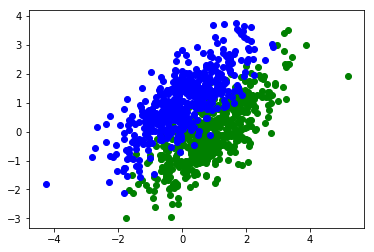

In [4]:
# data initial form
plt.scatter(x1[:, 0], x1[:, 1], c='g')
plt.scatter(x2[:, 0], x2[:, 1], c='b')

In [5]:
# generate testing data
x1_test = get_class0_data()
x2_test = get_class1_data()

In [6]:
# Utility functions
def confusion_matrix(true, post, threshold=0.5):
    """
    @param:
    true: true values
    post: posterior values
    threshold (default: 0.5): where to cut off
    
    @return: 
    confusion matrix [tp, fp, fn, tn]
     -----
    |TP|FN|
    |FP|TN|
     -----
    """
    
    tp, fp, fn, tn = 0, 0, 0, 0

    for x, y in zip(true, post):

        if x == 1 and y >= threshold:
            tp += 1
        elif x == 1 and y < threshold:
            fn += 1
        elif x == 0 and y >= threshold:
            fp += 1
        elif x == 0 and y < threshold:
            tn += 1
            
    return [tp, fp, fn, tn]

def print_metrics(true, post, return_metrics=False, no_print=False):
    """
    @param:
    true: array of true values
    post: array of predicted values
    
    @return: accuracy if return_metrics is set
    """
    
    tp, fp, fn, tn = confusion_matrix(true, post)
    
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    
    if not no_print:
        print(f'Accuracy: {(accuracy)*100}%')
        print(f'Precision: {(tp/(tp+fp))*100}%')
        print(f'Recall: {(tp/(tp+fn))*100}%')

        print('\nConfusion Matrix')
        print(' ---------------')
        print(f'|{tp}\t|{fp}\t|')
        print(f'|{fn}\t|{tn}\t|')
        print(' ---------------')
    
    return accuracy
    
def plot_predictions(pred, data):
    """
    @param: 
    pred: array of predictions (0, 1)
    data: test data
    
    @return: None
    """
    
    for x, k in zip(data, pred):
        # blue for class 1, green for class 2
        plt.plot(x[0], x[1], c='b' if k == 1.0 else 'g', marker='o', markersize=3)

# my naive bayes implementation

In [7]:
# naive bayes classifier function
def myNB(X, Y, X_test, Y_test):
    """
    params: X - training data
            Y - labels for training data(X)
            X_test - testing data
            Y_test - labels for testing data
            
    return: [pred, posterior, err]
            pred - predicted labels
            posterior - posterior probability
            err - error rate range: [0, 1]
    """
    
    # seperates X by class
    class0 = X[~Y.astype(bool)]
    class1 = X[Y.astype(bool)]
    
    # get mean, std of each class
    c0_mean, c0_std = class0.mean(axis=0), class0.std(axis=0)
    c1_mean, c1_std = class1.mean(axis=0), class1.std(axis=0)
    
    # probability of each class happening
    c0_prior = len(class0) / (len(class0) + len(class1))
    c1_prior = 1 - c0_prior
    
    # prediction step
    post = []
    pred = []
    
    for x, y in zip(X_test, Y_test):
        # class 0
        c0_prod = c0_prior * norm.pdf(x[0], loc=c0_mean[0], scale=c0_std[0]) * norm.pdf(x[1], loc=c0_mean[1], scale=c0_std[1])
        
        # class 1
        c1_prod = c1_prior * norm.pdf(x[0], loc=c1_mean[0], scale=c1_std[0]) * norm.pdf(x[1], loc=c1_mean[1], scale=c1_std[1])
    
        # normalized confidence of c1_probability
        post.append(c1_prod / (c0_prod + c1_prod))
        
        # 0 for class 0 prediction, 1 for class 1
        pred.append(c0_prod < c1_prod)
    
    # convert to ndarray
    post = np.array(post)
    pred = np.array(pred)
    
    # for error rate
    accuracy = print_metrics(Y_test, post, return_metrics=True, no_print=True)
    
    return pred, post, 1 - accuracy

# predictions

In [20]:
X = np.concatenate((x1, x2))
Y = np.concatenate((c0_labels, c1_labels))
X_test = np.concatenate((x1_test, x2_test))
Y_test = np.concatenate((np.zeros(500), np.ones(500)))

pred, post, err = myNB(X, Y, X_test, Y_test)
print_metrics(Y_test, post)

Accuracy: 92.30000000000001%
Precision: 91.88118811881189%
Recall: 92.80000000000001%

Confusion Matrix
 ---------------
|464	|41	|
|36	|459	|
 ---------------


0.923

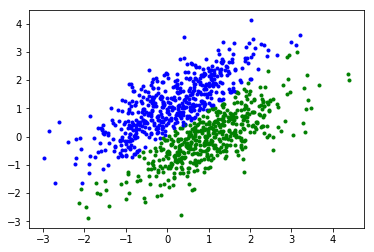

In [9]:
plot_predictions(pred, X_test)

# sklearn.naive_bayes for comparison

In [10]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(np.concatenate((X, X_test)), np.concatenate((Y, Y_test)))
predsk = gnb.predict(X_test)

In [11]:
print_metrics(Y_test, gnb.predict_proba(X_test)[:,1])

Accuracy: 92.10000000000001%
Precision: 91.35559921414537%
Recall: 93.0%

Confusion Matrix
 ---------------
|465	|44	|
|35	|456	|
 ---------------


0.921

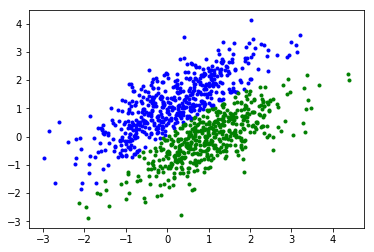

In [12]:
plot_predictions(predsk, X_test)

# my roc curve implementation

In [13]:
def my_roc_curve(true, post, auc=True):
    """
    @param
    true: array of true (actual) values
    post: array of predicted values
    auc(default: True): calculate auc aswell?
    
    @return
    out: (x, y) for points to plot roc curve
    auc: area under curve, if auc not set, returns -1
    """
    
    i = 0
    out = []
    
    while i < len(post):
        # get confusion matrix, post[i] is threshold
        tp, fp, fn, tn = confusion_matrix(true, post, post[i])
        
        # append [fpr, tpr] for plotting
        out.append([fp/(fp+tn), tp/(tp+fn)])
        
        i += 1
    
    out = np.array(out)
    
    # auc calculation
    area = -1
    if auc:
        area = 0
        i = 1
        
        # sorting so we have rectangle side by side
        sorted_out = out[np.argsort(out[:,0])]

        while i < len(out):
            # area = y * x[i] - x[i-1]
            area += sorted_out[i][1] * (sorted_out[i][0] - sorted_out[i-1][0])

            i += 1
    
    return out, area

In [14]:
# utility for roc plotting
def plot_roc_curve(true, post):
    """
    @param: 
    pred: array of predictions (0, 1)
    data: test data
    
    @return: None
    """
    
    out, area = my_roc_curve(true, post)
    plt.scatter(out[:, 0], out[:, 1])
    plt.text(.5, .5, f'AUC: {round(area*100)}%', fontsize=12)

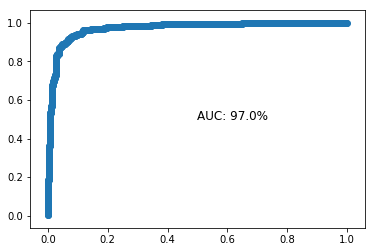

In [15]:
# balanced dataset roc curve
plot_roc_curve(Y_test, post)

# myNB predictions on different sized datasets



10 DATA POINTS!


Accuracy: 90.0%
Precision: 87.03703703703704%
Recall: 94.0%

Confusion Matrix
 ---------------
|470	|70	|
|30	|430	|
 ---------------


20 DATA POINTS!


Accuracy: 83.8%
Precision: 86.73913043478261%
Recall: 79.80000000000001%

Confusion Matrix
 ---------------
|399	|61	|
|101	|439	|
 ---------------


50 DATA POINTS!


Accuracy: 87.2%
Precision: 89.07563025210085%
Recall: 84.8%

Confusion Matrix
 ---------------
|424	|52	|
|76	|448	|
 ---------------


100 DATA POINTS!


Accuracy: 90.5%
Precision: 87.99249530956847%
Recall: 93.8%

Confusion Matrix
 ---------------
|469	|64	|
|31	|436	|
 ---------------


300 DATA POINTS!


Accuracy: 90.9%
Precision: 90.65606361829026%
Recall: 91.2%

Confusion Matrix
 ---------------
|456	|47	|
|44	|453	|
 ---------------


500 DATA POINTS!


Accuracy: 92.4%
Precision: 91.73228346456693%
Recall: 93.2%

Confusion Matrix
 ---------------
|466	|42	|
|34	|458	|
 ---------------


(0, 1)

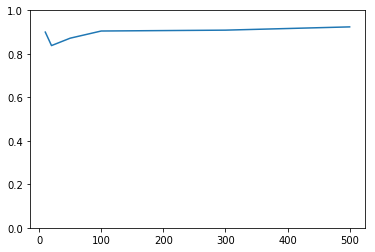

In [23]:
n_vs_accuracy = []

for n in [10, 20, 50, 100, 300, 500]:
    # generate n data points
    X = np.concatenate((get_class0_data(n), get_class1_data(n)))
    Y = np.concatenate((np.zeros(n), np.ones(n)))
#     X_test = np.concatenate((get_class0_data(n), get_class1_data(n)))
#     Y_test = np.concatenate((np.zeros(n), np.ones(n)))

    pred, post, err = myNB(X, Y, X_test, Y_test)
    
    print(f'\n\n{n} DATA POINTS!\n\n')
    accuracy = print_metrics(Y_test, post, return_metrics=True)
    
    n_vs_accuracy.append([n, accuracy])

n_vs_accuracy = np.array(n_vs_accuracy)
plt.plot(n_vs_accuracy[:, 0], n_vs_accuracy[:, 1])
plt.ylim(0, 1)

# myNB prediction on unbalanced dataset

Accuracy: 87.0%
Precision: 98.85057471264368%
Recall: 57.333333333333336%

Confusion Matrix
 ---------------
|172	|2	|
|128	|698	|
 ---------------


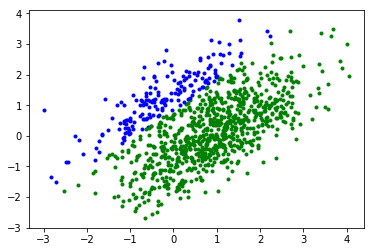

In [17]:
X = np.concatenate((get_class0_data(700), get_class1_data(300)))
Y = np.concatenate((np.zeros(700), np.ones(300)))
X_test = np.concatenate((get_class0_data(700), get_class1_data(300)))
Y_test = np.concatenate((np.zeros(700), np.ones(300)))

pred, post, err = myNB(X, Y, X_test, Y_test)
print_metrics(Y_test, post)
plot_predictions(pred, X_test)

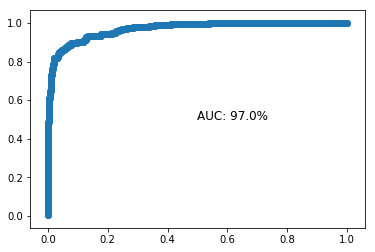

In [18]:
# roc curve for unbalanced dataset
plot_roc_curve(Y_test, post)

# sklearn comparison on unbalanced data

Accuracy: 86.4%
Precision: 98.80952380952381%
Recall: 55.333333333333336%

Confusion Matrix
 ---------------
|166	|2	|
|134	|698	|
 ---------------


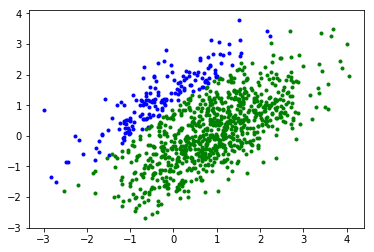

In [19]:
gnb = GaussianNB().fit(np.concatenate((X, X_test)), np.concatenate((Y, Y_test)))
predsk = gnb.predict(X_test)

print_metrics(Y_test, gnb.predict_proba(X_test)[:,1])
plot_predictions(predsk, X_test)